In [1]:
from google.cloud import bigquery # modulo para interactuar con la API y el service account del DW
import pandas as pd
import numpy as np
from plotnine import *
%matplotlib inline
def query_BQ(query_string):
    client = bigquery.Client() # inicializamos el cliente, pero antes se debe de fijar la variable de entorno 
    query_job = client.query(query_string)
    results = query_job.result().to_dataframe()  # Waits for job to complete and cast to pandas dataframe
    return(results)

In [2]:
from sklearn.preprocessing import scale
from h2o.automl import H2OAutoML
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ONaiveBayesEstimator
from sklearn.metrics import confusion_matrix
from google.cloud import bigquery # modulo para interactuar con la API y el service account del DW
import pandas as pd
import numpy as np
import h2o
import datetime
inicio = datetime.datetime.now()

In [3]:
query = '''
SELECT distinct user_id,
max(days_to_convert) as days_to_convert, /*Use only for analysis*/
max(days_to_take_FT) as days_to_take_FT,
max(device) as device,#

max(network) as adjust_network,
max(screen_height) as screen_height,
max(screen_width) as screenwidth,
max(android_app_version) as android_app_version,
max(android_lib_version) as android_lib_version /*.002 null class*/,
max(initial_assessment_completed) as initial_assessment_completed,
max(timezone) as timezone,
max(user_relationship) as user_relationship,
max(user_role) as user_role,
max(FT_start) as FT_start,
max(FT_conversion) as FT_conversion,
(case when country = 'US' then 1 else 2 end) as country,
kinedu_language,
y,
sum(case when video = "Completed" then 1 else 0 end) as Video_Completed,
sum(case when name ="OpenApp" then 1 else 0 end) as OpenApp,
sum(case when name ="LogOut" then 1 else 0 end) as LogOut,
sum(case when name ="S_DAPNewSkills" then 1 else 0 end) as S_DAPNewSkills,
sum(case when name ="AB_TEST" then 1 else 0 end) as AB_TEST,
sum(case when name ="S_SPHome" then 1 else 0 end) as S_SPHome,
sum(case when name ="S_SPLogin" then 1 else 0 end) as S_SPLogin,
sum(case when name ="LogIn" then 1 else 0 end) as LogIn,
sum(case when name ="SPForgotPass" then 1 else 0 end) as SPForgotPass,
sum(case when name ="S_SPSignup" then 1 else 0 end) as S_SPSignup,
sum(case when name ="SignUp" then 1 else 0 end) as SignUp,
sum(case when name ="OBCreateUser" then 1 else 0 end) as OBCreateUser,
sum(case when name ="S_OBBabyName" then 1 else 0 end) as S_OBBabyName,
sum(case when name ="OBCreateTwins" then 1 else 0 end) as OBCreateTwins,
sum(case when name ="S_OBPremature" then 1 else 0 end) as S_OBPremature,
sum(case when name ="Paywall_Dismiss" then 1 else 0 end) as Paywall_Dismiss,
sum(case when name ="S_InviteReceived" then 1 else 0 end) as S_InviteReceived,
sum(case when name ="InviteReceived" then 1 else 0 end) as InviteReceived,
sum(case when name ="S_Paywall_Soft" then 1 else 0 end) as S_Paywall_Soft,
sum(case when name ="CreateBaby" then 1 else 0 end) as CreateBaby,
sum(case when name ="S_IAIntro" then 1 else 0 end) as S_IAIntro,
sum(case when name ="IAStraightToActivities" then 1 else 0 end) as IAStraightToActivities,
sum(case when name ="IAStartAssessment" then 1 else 0 end) as IAStartAssessment,
sum(case when name ="IASkipAssessment" then 1 else 0 end) as IASkipAssessment,
sum(case when name ="MasterSkill" then 1 else 0 end) as MasterSkill,
sum(case when name ="IAFinishSkill" then 1 else 0 end) as IAFinishSkill,
sum(case when name ="S_IAHome " then 1 else 0 end) as S_IAHome ,
sum(case when name ="S_HealthInterest" then 1 else 0 end) as S_HealthInterest,
sum(case when name ="IAFinishAssessment" then 1 else 0 end) as IAFinishAssessment,
sum(case when name ="S_IASetReminder" then 1 else 0 end) as S_IASetReminder,
sum(case when name ="S_IAReminderSet" then 1 else 0 end) as S_IAReminderSet,
sum(case when name ="S_IAReminderContinue" then 1 else 0 end) as S_IAReminderContinue,
sum(case when name ="IAReminder" then 1 else 0 end) as IAReminder,
sum(case when name ="S_IA_Answer_Skill" then 1 else 0 end) as S_IA_Answer_Skill,
sum(case when name ="S_DAPHome " then 1 else 0 end) as S_DAPHome ,
sum(case when name ="DAPChangeActivity" then 1 else 0 end) as DAPChangeActivity,
sum(case when name ="S_DAPPastPlansPremium" then 1 else 0 end) as S_DAPPastPlansPremium,
sum(case when name ="DAPActivityCompleted" then 1 else 0 end) as DAPActivityCompleted,
sum(case when name ="DAPFullScreenActivity" then 1 else 0 end) as DAPFullScreenActivity,
sum(case when name ="S_DAPMaterials" then 1 else 0 end) as S_DAPMaterials,
sum(case when name ="MilestonesUpdate" then 1 else 0 end) as MilestonesUpdate,
sum(case when name ="Share " then 1 else 0 end) as Share ,
sum(case when name ="ArticleView" then 1 else 0 end) as ArticleView,
sum(case when name ="SlideshowView" then 1 else 0 end) as SlideshowView,
sum(case when name ="ActivityView" then 1 else 0 end) as ActivityView,
sum(case when name ="ClickInDAP" then 1 else 0 end) as ClickInDAP,
sum(case when name ="S_DSVidas " then 1 else 0 end) as S_DSVidas ,
sum(case when name ="RateActivityDAP" then 1 else 0 end) as RateActivityDAP,
sum(case when name ="Feedback_RateActivity" then 1 else 0 end) as Feedback_RateActivity,
sum(case when name ="Dismiss_Feedback_RateActivity" then 1 else 0 end) as Dismiss_Feedback_RateActivity,
sum(case when name ="LifeSpent" then 1 else 0 end) as LifeSpent,
sum(case when name ="WhatchAd" then 1 else 0 end) as WhatchAd,
sum(case when name ="VideoPlayerActivity" then 1 else 0 end) as VideoPlayerActivity,
sum(case when name ="ActivityDescription " then 1 else 0 end) as ActivityDescription ,
sum(case when name ="FreeTrialStart" then 1 else 0 end) as FreeTrialStart,
sum(case when name ="NPSSubmit" then 1 else 0 end) as NPSSubmit,
sum(case when name ="S_NPSScore" then 1 else 0 end) as S_NPSScore,
sum(case when name ="S_RWDashboard" then 1 else 0 end) as S_RWDashboard,
sum(case when name ="SkillsDetail " then 1 else 0 end) as SkillsDetail ,
sum(case when name ="S_ProgressHome" then 1 else 0 end) as S_ProgressHome,
sum(case when name ="S_ProgressSkillHome  " then 1 else 0 end) as S_ProgressSkillHome  ,
sum(case when name ="OverTime" then 1 else 0 end) as OverTime,
sum(case when name ="ComparedAge" then 1 else 0 end) as ComparedAge,
sum(case when name ="S_MenuFamilyHome" then 1 else 0 end) as S_MenuFamilyHome,
sum(case when name ="S_MenuSetReminders" then 1 else 0 end) as S_MenuSetReminders,
sum(case when name ="MenuHelp" then 1 else 0 end) as MenuHelp,
sum(case when name ="MenuMemberStats" then 1 else 0 end) as MenuMemberStats,
sum(case when name ="MenuFamilyInvite" then 1 else 0 end) as MenuFamilyInvite,
sum(case when name ="MenuChangeBirthday" then 1 else 0 end) as MenuChangeBirthday,
sum(case when name ="S_MenuEditBaby" then 1 else 0 end) as S_MenuEditBaby,
sum(case when name ="S_MenuUserProfile" then 1 else 0 end) as S_MenuUserProfile,
sum(case when name ="MenuFamilyDefault" then 1 else 0 end) as MenuFamilyDefault,
sum(case when name ="DailyReminders" then 1 else 0 end) as DailyReminders,
sum(case when name ="S_MenuFamilyProfile" then 1 else 0 end) as S_MenuFamilyProfile,
sum(case when name ="TAPCallToAction" then 1 else 0 end) as TAPCallToAction,
sum(case when name ="S_PremiumProcess" then 1 else 0 end) as S_PremiumProcess,
sum(case when name ="RestorePurchase" then 1 else 0 end) as RestorePurchase,
sum(case when name ="CATSkillDetail " then 1 else 0 end) as CATSkillDetail ,
sum(case when name ="S_CATHome_P" then 1 else 0 end) as S_CATHome_P,
sum(case when name ="S_CATHome_F" then 1 else 0 end) as S_CATHome_F,
sum(case when name ="S_CATSkill" then 1 else 0 end) as S_CATSkill,
sum(case when name ="CATSearch" then 1 else 0 end) as CATSearch,
sum(case when name ="S_CATViewSkill" then 1 else 0 end) as S_CATViewSkill,
sum(case when name ="S_CollectionView" then 1 else 0 end) as S_CollectionView,
sum(case when name ="ViewAllCollections" then 1 else 0 end) as ViewAllCollections,
sum(case when name ="S_Searcher " then 1 else 0 end) as S_Searcher ,
sum(case when name ="S_SearchResults " then 1 else 0 end) as S_SearchResults ,
sum(case when name ="S_SearchEmptyState" then 1 else 0 end) as S_SearchEmptyState,
sum(case when name ="ResetSearch" then 1 else 0 end) as ResetSearch,
sum(case when name ="S_CatalogHome " then 1 else 0 end) as S_CatalogHome ,
sum(case when name ="S_MilestonesHome" then 1 else 0 end) as S_MilestonesHome,
sum(case when name ="SkillsCardNotPersonalize " then 1 else 0 end) as SkillsCardNotPersonalize ,
sum(case when name ="SkillsViewAllSkills" then 1 else 0 end) as SkillsViewAllSkills,
sum(case when name ="S_PromoCode" then 1 else 0 end) as S_PromoCode,
sum(case when name ="PromoCodeRedeem" then 1 else 0 end) as PromoCodeRedeem,
sum(case when name ="S_FeedHome" then 1 else 0 end) as S_FeedHome,
sum(case when name ="InviteClassrooms" then 1 else 0 end) as InviteClassrooms,
sum(case when name ="shown" then 1 else 0 end) as shown,
sum(case when name ="clicked" then 1 else 0 end) as clicked,
sum(case when name ="dismissed" then 1 else 0 end) as dismissed
from
(
SELECT u.user_id,
timestamp_diff(ued.premium_conversion_date,u.created_at, day) as days_to_convert,/*Use only for analysis*/
timestamp_diff(ued.trial_start ,u.created_at, day) as days_to_take_FT,/*Use only for analysis*/
ev.name, ev.screen_height,ev.screen_width,ev.properties,
u.country,
u.kinedu_language,
u.network,
IF(ev.name= "VideoPlayerActivity" and JSON_EXTRACT(ev.properties, "$.video_completed")="true", "Completed", "Not Completed") as Video,
if (ev.device is null, 'NULL', ev.device) as device,
/*0.01915nulls */
if (p.android_app_version is null, 'NULL', android_app_version) as android_app_version, /*all related to android will be categoric 0.001 nulls*/
if( p.android_app_version_code is null, 'NULL', cast( android_app_version_code as string) ) as android_app_version_code,
if( android_brand is null, 'NULL', android_brand) as android_brand,
if(android_lib_version is null, 'NULL', android_lib_version)  as android_lib_version,
if(android_manufacturer is null, 'NULL', android_manufacturer) as android_manufacturer,
if(android_os_version is null, 'NULL', android_os_version) as android_os_version,
if(ued.premium_conversion_date is not null, 'Premium', 'Freemium') as y,
if(p.initial_assessment_completed is  null or initial_assessment_completed="NO", 0, 1) as initial_assessment_completed,
p.timezone,
if(p.user_relationship is null, 'NULL', user_relationship) as user_relationship,
if(p.user_role is null, 'NULL', user_role) as user_role,
if(ued.trial_start is not null, 1, 0) as FT_start,
if(ued.trial_converted is not null , 1, 0) as FT_conversion
FROM `celtic-music-240111.mixpanel.event` as ev
left join mixpanel.people as p
on p.distinct_id = ev.distinct_id
inner join celtic-music-240111.dbt_prod_caf.caf_users as u
on u.email = p.user_email
inner join aws_kinedu_app.user_extra_data as ued
on u.user_id = ued.user_id
where timestamp_MILLIS(ev.mp_processing_time_ms) >= '2020-01-01' and  timestamp_diff(timestamp_MILLIS(ev.mp_processing_time_ms) , u.created_at, day) < 1 /*only the first day events*/
and u.os='Android'
and u.network in ('Facebook', 'SMARTLY - Facebook', 'Facebook Installs', 'Instagram', 'SMARTLY - Instagram')
and (ued.premium_conversion_date not between '2020-03-16' and '2020-04-15' or premium_conversion_date is null)  /*null for add freemium users*/
and (timestamp_MILLIS(ev.mp_processing_time_ms) not between '2020-03-16' and '2020-04-15') #covid
and (u.created_at not between '2020-03-16' and '2020-04-15') #covid
and (u.created_at >='2020-01-01')
)
where kinedu_language in ('en') and country in('US','GB','CA','AU') and FT_start=0
group by user_id,y, country,kinedu_language
'''


In [4]:
import datetime
start = datetime.datetime.now()
raw_data = query_BQ(query)
end = datetime.datetime.now()
print(end - start)


0:01:19.730842


In [5]:
max(raw_data['user_id'])  #ÚLTIMO usuario que se utilizo para entrenar el modelo 

6763074

In [6]:
raw_data['y'].value_counts()

Freemium    84161
Premium      1666
Name: y, dtype: int64

In [7]:
NFT=raw_data[(raw_data.FT_start==0) & ((raw_data.days_to_convert<1) |(raw_data.days_to_convert.isnull()))]
NFT.describe()

user_id  days_to_convert  screen_height   screenwidth  \
count  8.461100e+04            450.0   84609.000000  84609.000000   
mean   5.630293e+06              0.0    2010.810978   1054.298680   
std    6.850467e+05              0.0     363.908595    180.844078   
min    4.444127e+06              0.0     782.000000    414.000000   
25%    4.887895e+06              0.0    2020.000000   1080.000000   
50%    5.749316e+06              0.0    2076.000000   1080.000000   
75%    6.176246e+06              0.0    2128.000000   1080.000000   
max    6.763074e+06              0.0    3120.000000   2892.000000   

       initial_assessment_completed  FT_start  FT_conversion       country  \
count                  84611.000000   84611.0        84611.0  84611.000000   
mean                       0.942608       0.0            0.0      1.431351   
std                        0.232592       0.0            0.0      0.495268   
min                        0.000000       0.0            0.0      1.000000   
25%                        1.000000       0.0            0.0      1.000000   
50%                        1.000000       0.0            0.0      1.000000   
75%                        1.000000       0.0            0.0      2.000000   
max                        1.000000       0.0            0.0      2.000000   

       Video_Completed       OpenApp      ...       S_MilestonesHome  \
count     84611.000000  84611.000000      ...           84611.000000   
mean          0.083181      2.230998      ...               0.564714   
std           0.407798      1.386497      ...               2.411282   
min           0.000000      0.000000      ...               0.000000   
25%           0.000000      1.000000      ...               0.000000   
50%           0.000000      2.000000      ...               0.000000   
75%           0.000000      3.000000      ...               0.000000   
max          22.000000     92.000000      ...              77.000000   

       SkillsCardNotPersonalize  SkillsViewAllSkills   S_PromoCode  \
count                   84611.0         84611.000000  84611.000000   
mean                        0.0             0.160854      0.007954   
std                         0.0             0.905634      0.128984   
min                         0.0             0.000000      0.000000   
25%                         0.0             0.000000      0.000000   
50%                         0.0             0.000000      0.000000   
75%                         0.0             0.000000      0.000000   
max                         0.0            24.000000      8.000000   

       PromoCodeRedeem    S_FeedHome  InviteClassrooms         shown  \
count     84611.000000  84611.000000      84611.000000  84611.000000   
mean          0.003238      0.068608          0.000213      1.674711   
std           0.090378      0.320566          0.016124      2.962477   
min           0.000000      0.000000          0.000000      0.000000   
25%           0.000000      0.000000          0.000000      0.000000   
50%           0.000000      0.000000          0.000000      0.000000   
75%           0.000000      0.000000          0.000000      3.000000   
max          10.000000     10.000000          2.000000    106.000000   

            clicked     dismissed  
count  84611.000000  84611.000000  
mean       0.020423      0.049462  
std        0.166824      0.272786  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        9.000000      7.000000  

[8 rows x 108 columns]

In [8]:
NFT['y'].value_counts()

Freemium    84161
Premium       450
Name: y, dtype: int64

In [9]:
raw_data1= raw_data.copy()

In [10]:
raw_data=NFT

In [11]:
raw_data['adjust_network'].unique()

array(['Facebook'], dtype=object)

In [12]:
networks= ['Instagram', 'Facebook','SMARTLY - Facebook','SMARTLY - Instagram']

In [13]:
raw_data= raw_data[raw_data['adjust_network'].isin(networks)]

In [14]:
raw_data['y'].value_counts()

Freemium    84161
Premium       450
Name: y, dtype: int64

In [15]:
del raw_data['user_id']
del raw_data['days_to_convert']
del raw_data['days_to_take_FT']
del raw_data['FT_start']
del raw_data['FT_conversion']

In [16]:
columns=list(raw_data[raw_data.describe().columns])
columns.append('y')

In [17]:
p_mean= raw_data[columns].groupby('y').mean().T
p_mean=p_mean[p_mean>0.0]
p_mean=p_mean.dropna()
p_mean

y                                Freemium      Premium
screen_height                 2010.427892  2082.455556
screenwidth                   1054.115888  1088.484444
initial_assessment_completed     0.942301     1.000000
country                          1.431815     1.344444
Video_Completed                  0.079491     0.773333
OpenApp                          2.213864     5.435556
S_DAPNewSkills                   0.002483     0.017778
AB_TEST                          0.297311     1.037778
S_SPHome                         1.908936     1.971111
S_SPLogin                        0.114424     0.195556
LogIn                            0.829850     0.860000
SPForgotPass                     0.001711     0.004444
SignUp                           1.003957     1.015556
OBCreateUser                     1.002365     1.011111
S_OBBabyName                     1.138520     1.257778
OBCreateTwins                    0.011383     0.026667
S_OBPremature                    0.102292     0.111111
Paywall_Dismiss                  0.501836     0.680000
S_Paywall_Soft                   0.644241     1.113333
CreateBaby                       0.911657     1.068889
S_IAIntro                        1.590404     1.624444
IAStraightToActivities           0.106712     0.073333
IAStartAssessment                0.780480     0.993333
IASkipAssessment                 0.403679     0.348889
MasterSkill                      0.070508     0.097778
IAFinishSkill                    3.956904     6.497778
S_HealthInterest                 0.354095     0.717778
IAFinishAssessment               0.353953     0.802222
S_IASetReminder                  0.095579     0.137778
S_IAReminderSet                  0.068048     0.093333
...                                   ...          ...
S_ProgressHome                   0.100937     2.311111
S_MenuFamilyHome                 0.400197     3.497778
MenuHelp                         0.001438     0.040000
MenuMemberStats                  0.014769     0.331111
MenuFamilyInvite                 0.000107     0.360000
MenuChangeBirthday               0.019023     0.046667
S_MenuEditBaby                   0.064210     0.424444
S_MenuUserProfile                0.075593     0.864444
MenuFamilyDefault                0.000749     0.048889
S_MenuFamilyProfile              0.071791     1.031111
TAPCallToAction                  0.139887     1.540000
S_PremiumProcess                 0.659225     3.706667
RestorePurchase                  0.004753     0.040000
S_CATHome_P                      0.006309     0.833333
S_CATHome_F                      0.184599     0.386667
S_CATSkill                       0.086964     1.046667
CATSearch                        0.001961     0.055556
S_CATViewSkill                   0.002412     0.104444
S_CollectionView                 0.085978     1.033333
ViewAllCollections               0.004040     0.088889
S_SearchEmptyState               0.000368     0.006667
S_MilestonesHome                 0.549887     3.337778
SkillsViewAllSkills              0.156759     0.926667
S_PromoCode                      0.007105     0.166667
PromoCodeRedeem                  0.002721     0.100000
S_FeedHome                       0.065173     0.711111
InviteClassrooms                 0.000202     0.002222
shown                            1.633892     9.308889
clicked                          0.017633     0.542222
dismissed                        0.048716     0.188889

[80 rows x 2 columns]

In [18]:
numerics=['MenuFamilyInvite',
 'S_DAPPastPlansPremium',
 'S_CATHome_P',
 'S_NPSScore',
 'NPSSubmit',
 'DAPActivityCompleted',
 'LogOut',
 'DAPChangeActivity',
 'S_ProgressHome',
 'ActivityView',
 'clicked',
 'S_MenuFamilyProfile',
 'Video_Completed',
 'MenuMemberStats',
 'MenuFamilyDefault',
 'shown',
 'MenuHelp',
 'S_CATViewSkill',
 'OpenApp',
 'PromoCodeRedeem',
 'FreeTrialStart',
 'S_MenuFamilyHome',
 'ViewAllCollections',
 'TAPCallToAction',
 'S_FeedHome',
 'S_MenuUserProfile',
 'Feedback_RateActivity',
 'CATSearch',
 'ArticleView',
 'S_CollectionView',
 'MilestonesUpdate',
 'S_PromoCode',
 'S_DAPMaterials',
 'Dismiss_Feedback_RateActivity',
 'RateActivityDAP',
 'SkillsViewAllSkills',
 'S_MilestonesHome',
 'SPForgotPass',
 'ClickInDAP',
 'S_DAPNewSkills']
numerics

['MenuFamilyInvite',
 'S_DAPPastPlansPremium',
 'S_CATHome_P',
 'S_NPSScore',
 'NPSSubmit',
 'DAPActivityCompleted',
 'LogOut',
 'DAPChangeActivity',
 'S_ProgressHome',
 'ActivityView',
 'clicked',
 'S_MenuFamilyProfile',
 'Video_Completed',
 'MenuMemberStats',
 'MenuFamilyDefault',
 'shown',
 'MenuHelp',
 'S_CATViewSkill',
 'OpenApp',
 'PromoCodeRedeem',
 'FreeTrialStart',
 'S_MenuFamilyHome',
 'ViewAllCollections',
 'TAPCallToAction',
 'S_FeedHome',
 'S_MenuUserProfile',
 'Feedback_RateActivity',
 'CATSearch',
 'ArticleView',
 'S_CollectionView',
 'MilestonesUpdate',
 'S_PromoCode',
 'S_DAPMaterials',
 'Dismiss_Feedback_RateActivity',
 'RateActivityDAP',
 'SkillsViewAllSkills',
 'S_MilestonesHome',
 'SPForgotPass',
 'ClickInDAP',
 'S_DAPNewSkills']

In [19]:
#raw_data[raw_data.y=="Freemium"]['days_in_app'].describe()

In [20]:
categorics = [ i for i in raw_data.columns if i not in raw_data.describe().columns]
categorics

['device',
 'adjust_network',
 'android_app_version',
 'android_lib_version',
 'timezone',
 'user_relationship',
 'user_role',
 'kinedu_language',
 'y']

In [21]:
raw_data[numerics].describe() #hay qe guardar la media y desviacion estandar de las variables numericas 

MenuFamilyInvite  S_DAPPastPlansPremium   S_CATHome_P    S_NPSScore  \
count      84611.000000           84611.000000  84611.000000  84611.000000   
mean           0.002021               0.003014      0.010708      0.000035   
std            0.056349               0.100008      0.309567      0.007687   
min            0.000000               0.000000      0.000000      0.000000   
25%            0.000000               0.000000      0.000000      0.000000   
50%            0.000000               0.000000      0.000000      0.000000   
75%            0.000000               0.000000      0.000000      0.000000   
max            3.000000              13.000000     35.000000      2.000000   

          NPSSubmit  DAPActivityCompleted        LogOut  DAPChangeActivity  \
count  84611.000000          84611.000000  84611.000000       84611.000000   
mean       0.000035              0.102776      0.000012           0.007103   
std        0.007687              0.475896      0.003438           0.103521   
min        0.000000              0.000000      0.000000           0.000000   
25%        0.000000              0.000000      0.000000           0.000000   
50%        0.000000              0.000000      0.000000           0.000000   
75%        0.000000              0.000000      0.000000           0.000000   
max        2.000000              9.000000      1.000000           7.000000   

       S_ProgressHome  ActivityView       ...        MilestonesUpdate  \
count    84611.000000  84611.000000       ...            84611.000000   
mean         0.112692      0.815107       ...                0.297609   
std          0.691776      1.500524       ...                1.386978   
min          0.000000      0.000000       ...                0.000000   
25%          0.000000      0.000000       ...                0.000000   
50%          0.000000      0.000000       ...                0.000000   
75%          0.000000      1.000000       ...                0.000000   
max         58.000000    100.000000       ...               49.000000   

        S_PromoCode  S_DAPMaterials  Dismiss_Feedback_RateActivity  \
count  84611.000000    84611.000000                   84611.000000   
mean       0.007954        0.164104                       0.005768   
std        0.128984        0.444249                       0.083022   
min        0.000000        0.000000                       0.000000   
25%        0.000000        0.000000                       0.000000   
50%        0.000000        0.000000                       0.000000   
75%        0.000000        0.000000                       0.000000   
max        8.000000        8.000000                       4.000000   

       RateActivityDAP  SkillsViewAllSkills  S_MilestonesHome  SPForgotPass  \
count     84611.000000         84611.000000      84611.000000  84611.000000   
mean          0.003215             0.160854          0.564714      0.001726   
std           0.062747             0.905634          2.411282      0.083770   
min           0.000000             0.000000          0.000000      0.000000   
25%           0.000000             0.000000          0.000000      0.000000   
50%           0.000000             0.000000          0.000000      0.000000   
75%           0.000000             0.000000          0.000000      0.000000   
max           5.000000            24.000000         77.000000     13.000000   

         ClickInDAP  S_DAPNewSkills  
count  84611.000000    84611.000000  
mean       0.004704        0.002565  
std        0.079750        0.056536  
min        0.000000        0.000000  
25%        0.000000        0.000000  
50%        0.000000        0.000000  
75%        0.000000        0.000000  
max        4.000000        4.000000  

[8 rows x 40 columns]

In [22]:
raw_data['adjust_network'].value_counts()

Facebook    84611
Name: adjust_network, dtype: int64

In [23]:
numerics

['MenuFamilyInvite',
 'S_DAPPastPlansPremium',
 'S_CATHome_P',
 'S_NPSScore',
 'NPSSubmit',
 'DAPActivityCompleted',
 'LogOut',
 'DAPChangeActivity',
 'S_ProgressHome',
 'ActivityView',
 'clicked',
 'S_MenuFamilyProfile',
 'Video_Completed',
 'MenuMemberStats',
 'MenuFamilyDefault',
 'shown',
 'MenuHelp',
 'S_CATViewSkill',
 'OpenApp',
 'PromoCodeRedeem',
 'FreeTrialStart',
 'S_MenuFamilyHome',
 'ViewAllCollections',
 'TAPCallToAction',
 'S_FeedHome',
 'S_MenuUserProfile',
 'Feedback_RateActivity',
 'CATSearch',
 'ArticleView',
 'S_CollectionView',
 'MilestonesUpdate',
 'S_PromoCode',
 'S_DAPMaterials',
 'Dismiss_Feedback_RateActivity',
 'RateActivityDAP',
 'SkillsViewAllSkills',
 'S_MilestonesHome',
 'SPForgotPass',
 'ClickInDAP',
 'S_DAPNewSkills']

In [24]:
fcols= numerics.copy()
fcols.append('country')
fcols.append('y')

In [25]:
data= raw_data[fcols]

In [26]:
data=data.dropna()

In [28]:
#data['adjust_network'].unique()

In [ ]:
#cleanup_nums = {"adjust_network":{'Facebook':4,'Instagram':3, 'SMARTLY - Facebook':2,'SMARTLY - Instagram':1}}

In [ ]:
#data.replace(cleanup_nums, inplace=True)

In [29]:
X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split #impor

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']=='Freemium']))
print("Number of subscription",len(os_data_y[os_data_y['y']=='Premium']))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='Freemium'])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='Premium'])/len(os_data_X))

/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  117864
Number of no subscription in oversampled data 58932
Number of subscription 58932
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [30]:
raw_data=os_data_X.join(os_data_y)

In [ ]:
#cleanup_nums = {"adjust_network":{4:'Facebook',3:'Instagram', 2:'SMARTLY - Facebook',1:'SMARTLY - Instagram'}}
#raw_data.replace(cleanup_nums, inplace=True)

In [ ]:
#numerics=list(p_mean.index)


In [31]:
X = scale(raw_data[numerics])
X = pd.DataFrame(X)
X.columns = numerics
#catego= 'adjust_network'
catego= 'country'

In [32]:
#Prueba Xi   --Variables Númericas
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
y= raw_data['y']

In [34]:
bestfeatures = SelectKBest(score_func=chi2, k="all")
X= abs(X)
y
fit= bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(40,'Score').reset_index(drop=True))


                          Feature         Score
0                MenuFamilyInvite  10902.899289
1                     S_CATHome_P   9097.600447
2           S_DAPPastPlansPremium   8626.138401
3                         clicked   7923.278163
4                 PromoCodeRedeem   7071.209670
5                     S_PromoCode   7069.858873
6                 MenuMemberStats   6860.921417
7           Feedback_RateActivity   6674.008696
8              ViewAllCollections   6263.177019
9               DAPChangeActivity   6193.645942
10               S_CollectionView   5758.125318
11                 S_CATViewSkill   5638.509739
12                Video_Completed   5631.673984
13           DAPActivityCompleted   5529.292123
14              S_MenuUserProfile   5525.101654
15                      CATSearch   5410.797598
16            SkillsViewAllSkills   5297.519659
17            S_MenuFamilyProfile   5043.283399
18                 S_ProgressHome   4904.183689
19  Dismiss_Feedback_RateActivity   4840

In [35]:
feat= featureScores.nlargest(33,'Score').Feature
feat=feat.tolist()
#feat= feat[1:]
feat.remove('S_DAPPastPlansPremium')
feat

['MenuFamilyInvite',
 'S_CATHome_P',
 'clicked',
 'PromoCodeRedeem',
 'S_PromoCode',
 'MenuMemberStats',
 'Feedback_RateActivity',
 'ViewAllCollections',
 'DAPChangeActivity',
 'S_CollectionView',
 'S_CATViewSkill',
 'Video_Completed',
 'DAPActivityCompleted',
 'S_MenuUserProfile',
 'CATSearch',
 'SkillsViewAllSkills',
 'S_MenuFamilyProfile',
 'S_ProgressHome',
 'Dismiss_Feedback_RateActivity',
 'S_FeedHome',
 'S_MilestonesHome',
 'shown',
 'ArticleView',
 'S_MenuFamilyHome',
 'ActivityView',
 'ClickInDAP',
 'MenuHelp',
 'RateActivityDAP',
 'MilestonesUpdate',
 'S_DAPMaterials',
 'FreeTrialStart',
 'S_DAPNewSkills']

/root/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[8.58554136e-02 2.74693894e-02 4.34685536e-02 0.00000000e+00
 0.00000000e+00 6.62484679e-02 0.00000000e+00 3.70174005e-03
 5.34467131e-02 4.58414972e-02 5.21643743e-02 3.47999074e-02
 3.55341529e-02 5.47436476e-03 4.52077187e-04 5.53810399e-02
 2.13755398e-04 2.00184465e-03 5.48426044e-02 1.70884738e-03
 3.55823882e-04 2.44093280e-02 7.29577655e-03 1.49947088e-01
 3.03020388e-02 1.95683604e-02 5.74788869e-03 2.79232443e-03
 1.08551028e-02 1.95689573e-02 6.95700571e-03 9.68449691e-03
 1.12051849e-01 2.30059867e-03 6.57055422e-04 9.59253949e-03
 6.35097587e-03 3.54105859e-05 1.09021797e-02 2.02045666e-03]


MenuFamilyInvite                 0.085855
S_DAPPastPlansPremium            0.027469
S_CATHome_P                      0.043469
S_NPSScore                       0.000000
NPSSubmit                        0.000000
DAPActivityCompleted             0.066248
LogOut                           0.000000
DAPChangeActivity                0.003702
S_ProgressHome                   0.053447
ActivityView                     0.045841
clicked                          0.052164
S_MenuFamilyProfile              0.034800
Video_Completed                  0.035534
MenuMemberStats                  0.005474
MenuFamilyDefault                0.000452
shown                            0.055381
MenuHelp                         0.000214
S_CATViewSkill                   0.002002
OpenApp                          0.054843
PromoCodeRedeem                  0.001709
FreeTrialStart                   0.000356
S_MenuFamilyHome                 0.024409
ViewAllCollections               0.007296
TAPCallToAction                  0

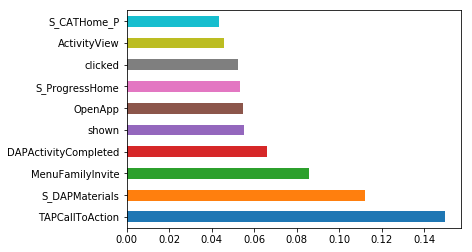

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
#plt.show()
feat_importances


In [37]:
catego= 'country'

In [38]:
h2o.init(min_mem_size = 200)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /root/anaconda3/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbuxvxven
  JVM stdout: /tmp/tmpbuxvxven/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbuxvxven/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.1
H2O cluster version age:    1 year, 4 months and 17 days !!!
H2O cluster name:           H2O_from_python_unknownUser_i6xnyc
H2O cluster total nodes:    1
H2O cluster free memory:    200 Gb
H2O cluster total cores:    70
H2O cluster allowed cores:  70
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.5.6 final
--------------------------  ---------------------------------------------------

In [39]:
N= raw_data[feat]
C= raw_data[catego]
Y= raw_data['y']
df= pd.concat( [N, C, Y  ], axis = 1)

In [40]:
X_hf = h2o.H2OFrame(df)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [41]:
train, test = X_hf.split_frame(ratios = [.7], seed=0)

In [42]:
 X_hf.describe()

Rows:117864
Cols:34




MenuFamilyInvite S_CATHome_P clicked PromoCodeRedeem S_PromoCode MenuMemberStats Feedback_RateActivity ViewAllCollections DAPChangeActivity S_CollectionView S_CATViewSkill Video_Completed DAPActivityCompleted S_MenuUserProfile CATSearch SkillsViewAllSkills S_MenuFamilyProfile S_ProgressHome Dismiss_Feedback_RateActivity S_FeedHome S_MilestonesHome shown ArticleView S_MenuFamilyHome ActivityView ClickInDAP MenuHelp RateActivityDAP MilestonesUpdate S_DAPMaterials FreeTrialStart S_DAPNewSkills country y 
 
 
 type real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real real enum 
 mins 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 
 mean 0.15402356906061743 0.31059510504623533 0.22834342372700972 0.03357497073575024 0.06332399335338051 0.11308811577503397 0.1682735491251552 0.028044926707408307 0.042496065042885056 0.41337713772838425 0.02323205405023149 0.3808830764897113 0.5154641041942079 0.39231706247873643 0.018891226058566166 0.46411626234926706 0.45762436627493613 0.890579754364821 0.026517466328349455 0.3614360448184064 1.7563761886365798 4.946483391474458 0.32331983608078113 1.7323644802356506 2.651502190240797 0.01819245209574241 0.009783875684297406 0.009491007582560088 0.903222916772224 0.5315717588175223 0.0012648736656065908 0.00690740827871254 1.3800181194414145 
 maxs 3.0 33.0 4.0 10.0 8.0 9.0 10.0 3.0 6.0 14.0 22.0 22.0 9.0 18.0 8.0 24.0 15.0 58.0 4.0 9.0 68.0 74.0 37.0 37.0 100.0 4.0 4.0 5.0 49.0 8.0 1.0 4.0 2.0 
 sigma 0.4014547822863944 1.1314465534865814 0.5326001960171974 0.206080220867157 0.34587514061135655 0.5935637157184461 0.6245143045786965 0.1650454555539768 0.24862516749577948 1.1450582711042296 0.18310853120887316 0.9905794331633927 1.1100527954183619 1.1135482446182499 0.1531739104580104 1.5339257174882956 1.1190767234266943 2.4804988786274826 0.1680852022377744 0.798680947020138 5.00930911671683 7.412689951877717 1.37088746782852 2.9799422319061133 4.317880653320791 0.15979803372931667 0.1225163619310427 0.08590515528639772 2.256068054876698 0.861477193282392 0.02926699443891554 0.07275336110134911 0.44982774354501565 
 zeros 94638 99452 88392 112728 111251 110102 105571 112706 112403 91213 114715 88208 82753 88613 115236 104259 80101 77708 113292 80044 72815 34143 92809 57455 44996 114989 116535 115859 77045 67179 117581 116400 0 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Freemium 
 1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 Freemium 
 2 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 Freemium 
 3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Freemium 
 4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 3.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 Freemium 
 5 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Freemium 
 6 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Freemium 
 7 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Freemium 
 8 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 Freemium 
 9 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.

In [43]:
feat= X_hf.columns[:-1]
feat

['MenuFamilyInvite',
 'S_CATHome_P',
 'clicked',
 'PromoCodeRedeem',
 'S_PromoCode',
 'MenuMemberStats',
 'Feedback_RateActivity',
 'ViewAllCollections',
 'DAPChangeActivity',
 'S_CollectionView',
 'S_CATViewSkill',
 'Video_Completed',
 'DAPActivityCompleted',
 'S_MenuUserProfile',
 'CATSearch',
 'SkillsViewAllSkills',
 'S_MenuFamilyProfile',
 'S_ProgressHome',
 'Dismiss_Feedback_RateActivity',
 'S_FeedHome',
 'S_MilestonesHome',
 'shown',
 'ArticleView',
 'S_MenuFamilyHome',
 'ActivityView',
 'ClickInDAP',
 'MenuHelp',
 'RateActivityDAP',
 'MilestonesUpdate',
 'S_DAPMaterials',
 'FreeTrialStart',
 'S_DAPNewSkills',
 'country']

In [44]:
nam= ['CeliaENgbm','CeliaENDRF','CeliaENGLM','CeliaENXGB']
#feat.append('timezone')

#Var= ['language', 'mp_region', 'city', 'signup_provider', 'timezone', 'user_gender',
 #              'email_domain', 'adjust_network', 'baby_gender', 'weeks_before_birth', 
  #             'baby_age_at_signup_meses', 'edad_bebe_actual_meses']

gbm = H2OGradientBoostingEstimator(model_id = nam[0], seed = 0, balance_classes=True,  nfolds = 10)
gbm.train(  x= feat, y='y', training_frame=train)

DRF = H2ORandomForestEstimator(model_id = nam[1], seed = 0, balance_classes=True, binomial_double_trees=True,  nfolds = 10)
DRF.train(  x= feat, y='y', training_frame=train)

GLM = H2OGeneralizedLinearEstimator(model_id = nam[2], seed = 0,family = 'binomial',  nfolds = 10)
GLM.train(  x= feat, y='y', training_frame=train)

XGB = H2OXGBoostEstimator(model_id = nam[3], seed = 0,  nfolds = 10)
XGB.train(  x= feat, y='y', training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%
xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [45]:
m= ['gbm','DRF','GLM','XGB']
nam= ['CeliaENgbm','CeliaENDRF','CeliaENGLM','CeliaENXGB']

gbmf =  gbm.model_performance(test).confusion_matrix().to_list()
ger= gbmf[1][0]/(gbmf[1][0]+gbmf[1][1])

DRFf =  DRF.model_performance(test).confusion_matrix().to_list()
DRFer= DRFf[1][0]/(DRFf[1][0]+DRFf[1][1])

GLMf =  GLM.model_performance(test).confusion_matrix().to_list()
GLMer= GLMf[1][0]/(GLMf[1][0]+GLMf[1][1])

XGBf =  XGB.model_performance(test).confusion_matrix().to_list()
XGBer= XGBf[1][0]/(XGBf[1][0]+XGBf[1][1])

er= [ger,DRFer,GLMer,XGBer]
data = {'Model':nam,
       'Error':er}

data= pd.DataFrame(data)
data

Error       Model
0  0.021908  CeliaENgbm
1  0.011265  CeliaENDRF
2  0.114577  CeliaENGLM
3  0.004302  CeliaENXGB

In [46]:
gbm.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4063480174879473: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ---------------
Freemium  17430       241        0.0136   (241.0/17671.0)
Premium   387         17278      0.0219   (387.0/17665.0)
Total     17817       17519      0.0178   (628.0/35336.0)

In [47]:
GLM.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3612946499763141: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ----------------
Freemium  15821       1850       0.1047   (1850.0/17671.0)
Premium   2024        15641      0.1146   (2024.0/17665.0)
Total     17845       17491      0.1096   (3874.0/35336.0)

In [48]:
DRF.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36456200199217337: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ---------------
Freemium  17575       96         0.0054   (96.0/17671.0)
Premium   199         17466      0.0113   (199.0/17665.0)
Total     17774       17562      0.0083   (295.0/35336.0)

In [49]:
XGB.model_performance(test).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46233201026916504: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  --------------
Freemium  17654       17         0.001    (17.0/17671.0)
Premium   76          17589      0.0043   (76.0/17665.0)
Total     17730       17606      0.0026   (93.0/35336.0)

In [50]:
feat

['MenuFamilyInvite',
 'S_CATHome_P',
 'clicked',
 'PromoCodeRedeem',
 'S_PromoCode',
 'MenuMemberStats',
 'Feedback_RateActivity',
 'ViewAllCollections',
 'DAPChangeActivity',
 'S_CollectionView',
 'S_CATViewSkill',
 'Video_Completed',
 'DAPActivityCompleted',
 'S_MenuUserProfile',
 'CATSearch',
 'SkillsViewAllSkills',
 'S_MenuFamilyProfile',
 'S_ProgressHome',
 'Dismiss_Feedback_RateActivity',
 'S_FeedHome',
 'S_MilestonesHome',
 'shown',
 'ArticleView',
 'S_MenuFamilyHome',
 'ActivityView',
 'ClickInDAP',
 'MenuHelp',
 'RateActivityDAP',
 'MilestonesUpdate',
 'S_DAPMaterials',
 'FreeTrialStart',
 'S_DAPNewSkills',
 'country']

In [51]:
n1 = list(np.arange(50, 500, 110 ))
n2 =  list(np.arange(20, 242, 120))
params = { 'ntrees': n1, 'max_depth' : n2 }
XGB = H2OXGBoostEstimator(model_id = "en", seed = 0,  nfolds = 10)
#RF = H2ORandomForestEstimator(model_id = "CeliaUSOsFTDRF", seed = 0, balance_classes=True, binomial_double_trees=True,  nfolds = 10)
#gbm = H2OGradientBoostingEstimator(model_id = "USgbm", seed = 0, balance_classes=True,  nfolds = 10)
grid = H2OGridSearch(model=XGB, hyper_params=params)
params 

{'max_depth': [20, 140], 'ntrees': [50, 160, 270, 380, 490]}

In [52]:
grid.train(x=feat, y= 'y', training_frame = train , validation_frame=test)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [53]:
grid_train = grid.get_grid(sort_by='recall', decreasing=True )
grid_train 

    max_depth ntrees  \
0          20    380   
1          20    270   
2         140    380   
3         140    490   
4         140    270   
5          20    490   
6         140    160   
7          20     50   
8         140     50   
9          20    160   

                                                             model_ids  \
0   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_7   
1   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_5   
2   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_8   
3  Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_10   
4   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_6   
5   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_9   
6   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_4   
7   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_1   
8   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_

In [54]:
path='/home/fbfakeevents/Conversion/BehaviorMixpanel/Models/aOS/EN'

g = grid_train
print(g.grid_id)
print(g)
for i, m in enumerate(g.models):
    print("Save model" + m.model_id + " to " + path + "/" + m.model_id)
    h2o.save_model(model=m, path=path, force=True)

Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528
    max_depth ntrees  \
0          20    380   
1          20    270   
2         140    380   
3         140    490   
4         140    270   
5          20    490   
6         140    160   
7          20     50   
8         140     50   
9          20    160   

                                                             model_ids  \
0   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_7   
1   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_5   
2   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_8   
3  Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_10   
4   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_6   
5   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_9   
6   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_4   
7   Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_1   
8   Grid_X

In [ ]:
#import os
#os.remove("ChangedFile.csv")
#print("File Removed!")
#Para borrar entrenados que no sirven 

In [55]:
## model = grid_train.models[0]
model =  h2o.load_model(path+ '/'+ 'Grid_XGBoost_py_3_sid_aac6_model_python_1606954809514_1528_model_7')
#model

In [56]:
model.model_performance(train).confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.447603702545166: 


Freemium    Premium    Error    Rate
--------  ----------  ---------  -------  ---------------
Freemium  41258       3          0.0001   (3.0/41261.0)
Premium   98          41169      0.0024   (98.0/41267.0)
Total     41356       41172      0.0012   (101.0/82528.0)

In [57]:
roc = model.model_performance(test_data=test, train=train)

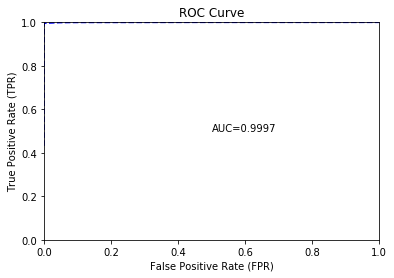

In [58]:
roc.plot()